# Gappy Data Preprocessing Tests
:auth: Nathan T. Stevens
:email: ntsteven at uw.edu
:org: Pacific Northwest Seismic Network


In [11]:
import os
import sys
import numpy as np
from tqdm import tqdm
from obspy import read, UTCDateTime, Stream
from glob import glob
import prediction_methods as ml
import ml_multistation_tests as pp
import matplotlib.pyplot as plt
from pyrocko import obspy_compat
%matplotlib widget
obspy_compat.plant()

In [2]:
# Define path to MSEED day_volumes
DATA_DIR = os.path.join('/Volumes', 'LaCie', 'PNW_Store_Local')
# Compose search string for glob.glob
GLOB_STR = os.path.join(DATA_DIR, 'PNW2017','UW','2017','131','*')
# Define time bounds for obspy.read
TS = UTCDateTime(2017,5,11,13,45)
TE = UTCDateTime(2017,5,11,14,5)

In [3]:
# Get data with gaps
flist = glob(GLOB_STR)
flist.sort()
stream = Stream()
for _f in tqdm(flist):
    stream += read(_f, fmt='MSEED')
stream.trim(starttime=TS, endtime=TE)


100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


2692 Trace(s) in Stream:

UW.ALKI..HNE | 2017-05-11T13:45:00.000000Z - 2017-05-11T14:05:00.000000Z | 200.0 Hz, 240001 samples
...
(2690 other traces)
...
UW.VVHS..ENZ | 2017-05-11T13:56:32.990000Z - 2017-05-11T14:05:00.000000Z | 100.0 Hz, 50702 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [4]:
# Get model
model, device = ml.initialize_EQT_model()

# Test 1: Do Nothing
Check if gappy data produces valid (non-NaN, but perhaps still gappy) model values


In [8]:
# Prepare data
# Break into NSBI 
st_dict = pp._get_unique_NSBI_from_stream(stream.merge(method=0))
# Resample data to 100 sps
st_dict = pp._resample_testdata(st_dict)
# Window data
windows, swindex = pp._build_windowed_array(st_dict, model, method_1C='DUP')
# Taper data
windows = pp._apply_taper(windows)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [9]:
# Run batched prediction
pred = ml.run_batched_prediction(windows, model, device, batch_size=10)

100%|██████████| 184/184 [00:13<00:00, 13.94it/s]


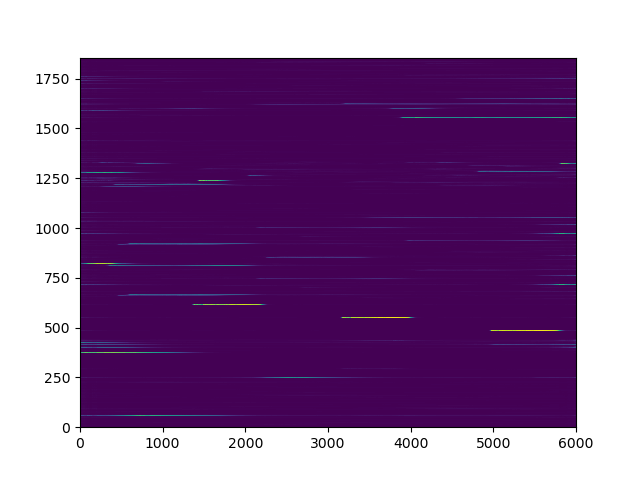

In [12]:
plt.figure()
plt.pcolor(pred[:,0,:])

In [7]:
# Convert windows back to stream
pred_st = pp._reassemble_multistation(pred, swindex, model, st_dict)

/Users/nates/Code/PNSN/Sci-Prod-ML/ml_prediction/prediction_methods.py:290: RuntimeWarning: All-NaN axis encountered
  stack[:, _wi:_wi+mdata] = merge_method([stack[:, _wi:_wi+mdata], _data], axis=0)


ValueError: startime is larger than endtime

In [ ]:
# Check resampled data
st2 = Stream()
for _k in st_dict.keys():
    st2 += st_dict[_k]
st2.snuffle(ntracks=90)